# DS 211 Numerical Optimization
## **Problem Set 1**



## **Question : 1** 


 **Linear Least Squares** **[5 points]**


The simplest model to predict the spread of infectious diseases is the SIR model. This model is a set of ordinary differential equations that describe the evolution of the number of susceptible (S(t)), infected (I(t)) and recovered/removed (R(t)) populations in a closed system. The equations are

$\frac{dS}{dt} = \frac {−βIS} {N} $, (1)

$\frac{dI}{dt} =\frac {βIS} {N} −γI$, (2)

$\frac{dR}{dt} = γI$, (3)

where $N = S(t)+I(t)+R(t)$. The basic reproduction number $R_0 = β/γ$ is defined to quantify the new infections that one infected person causes and is considered as a magic number to identify if an infectious disease is under control. For example, if $R_0 > 1$, the disease has an exponential growth whereas if $R_0 < 1$, the disease is under control and the infectious population will eventually go to zero. At peak $R_0$ will cross 1.
As with simple models, there exist analytical solutions to the SIR model. One form of the solution is given as

$S(t) = S(0) exp(−χ(t))$ , (4)

$I(t) = N − S(t) − R(t)$ , (5)

$R(t) = R(0) + ρχ(t)$ , (6)

$χ(t) = \frac {β} {N} \int_{0}^{t}I(t^*) dt^*$. (7)


For this assignment, we will consider a time unit of days, total population of India as 130 crores and the time horizon of interest as March 23, 2020 to Oct 15, 2020. Removed is a sum of recovered and deceased, i.e., the population that will not get infected again. Data in CSV form for state-wise-daily is available at
https://data.covid19india.org/csv/latest/state_wise_daily.csv

1. Download the state wise daily data of infected, recovered and deceased from the covid19india website. The data gives daily new infections, recovery and deceased. Use Pandas and create time-series of all India $I(t), S(t)$ and $R(t)$. Plot these time- series. Hint: Apply yourself and see what $I(t)$ means and what the data provides.
2. Formulate the problem of estimating $γ$ and $β$ as a linear least squares problem.
3. Form the Jacobian matrix and calculate its rank and condition number.
4. Form the coefficient matrix and calculate its condition number. Find the relation between this condition number and condition number of the Jacobian.
5. Code the cholesky factorization approach to solve the linear least squares problem.
6. Apply your code and estimate $β, γ$ and $R_0$.
7. Use scipy.optimize and estimate $β, γ$ and $R_0$.
8. State your observations in the above two items and give reasons.
9. Estimate $R_0(t)$ as a function of time by utilizing data until t to estimate the different parameters. Plot $R_0(t)$. 
10. Based on the above analyse the state of the pandemic in India. Has the peak passed as on Oct 2020?

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cho_solve
import scipy

In [2]:
df = pd.read_csv(
    'https://data.covid19india.org/csv/latest/state_wise_daily.csv')

i_cutoff_date = pd.Timestamp(2020, 3, 23)
df['Date_YMD'] = pd.to_datetime(df['Date_YMD'], infer_datetime_format=True)

infected_df = df[df['Status'] == 'Confirmed']
recovered_df = df[(df['Status'] == 'Recovered') | (df['Status'] == 'Deceased')]
TOTAL_POPULATION = 1.3 * (10**9)

In [3]:
infected_df = infected_df[['Date_YMD', 'TT']].reset_index(drop='True')
recovered_df = recovered_df[['Date_YMD', 'TT']].reset_index(drop='True')
recovered_df = recovered_df.groupby(by='Date_YMD', as_index=False).sum()

In [4]:
infected_df.rename(columns={'TT': 'Infected'}, inplace=True)
recovered_df.rename(columns={'TT': 'Recovered'}, inplace=True)

In [5]:
entire_df = pd.concat([infected_df, recovered_df],join= "inner")
entire_df = infected_df.merge(recovered_df, how='inner', on='Date_YMD')
entire_df['Total_Population'] = int(TOTAL_POPULATION)

In [6]:
entire_df['Infected_'] = entire_df['Infected'].cumsum()
entire_df['Recovered_'] = entire_df['Recovered'].cumsum()
entire_df['Total_'] = entire_df['Infected_'] + entire_df['Recovered_']
entire_df['Susceptible'] = TOTAL_POPULATION - entire_df['Infected_']
entire_df['N'] = entire_df['Infected_'] + entire_df['Recovered_'] + entire_df[
    'Susceptible']
entire_df['Infected_today'] = entire_df['Infected_'] - entire_df['Recovered_']

In [7]:
entire_df = entire_df[entire_df['Date_YMD'] >= i_cutoff_date]
entire_df = entire_df[[
    'Date_YMD', 'Infected', 'Infected_', 'Infected_today', 'Recovered',
    'Recovered_', 'Susceptible', 'N'
]]

In [8]:
cutoff_date = pd.Timestamp(2020, 10, 15)
entire_df['Date_YMD'] = pd.to_datetime(entire_df['Date_YMD'],
                                       infer_datetime_format=True)

In [9]:
entire_df = entire_df[entire_df['Date_YMD'] <= cutoff_date]
entire_df.reset_index(inplace=True, drop=True)

In [10]:
entire_df

,Date_YMD,Infected,Infected_,Infected_today,Recovered,Recovered_,Susceptible,N
0,2020-03-23,102,503,459,14,44,1.299999e+09,1.300000e+09
1,2020-03-24,64,567,517,6,50,1.299999e+09,1.300000e+09
2,2020-03-25,90,657,603,4,54,1.299999e+09,1.300000e+09
3,2020-03-26,65,722,656,12,66,1.299999e+09,1.300000e+09
4,2020-03-27,164,886,791,29,95,1.299999e+09,1.300000e+09
...,...,...,...,...,...,...,...,...
202,2020-10-11,67789,7118668,863073,72378,6255595,1.292881e+09,1.306256e+09
203,2020-10-12,54262,7172930,838260,79075,6334670,1.292827e+09,1.306335e+09
204,2020-10-13,63717,7236647,827171,74806,6409476,1.292763e+09,1.306409e+09
205,2020-10-14,67811,7304458,812710,82272,6491748,1.292696e+09,1.306492e+09


# Question 01 - 01

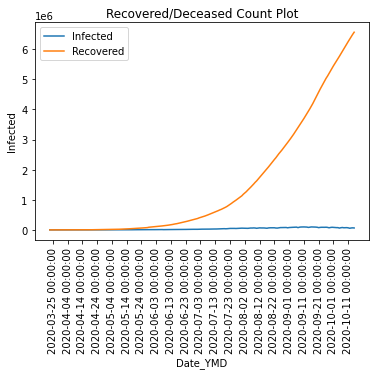

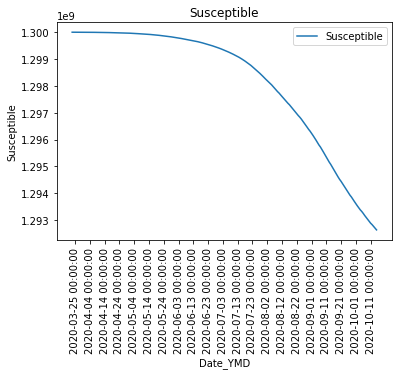

In [11]:
need_plot = True
if need_plot:
    plt.figure()
    infected_plot = sns.lineplot(x=entire_df['Date_YMD'],
                                 y=entire_df['Infected'],
                                 label='Infected')
    infected_plot.set(xticks=entire_df['Date_YMD'][2::10])
    infected_plot.set_xticklabels(labels=entire_df['Date_YMD'][2::10],
                                  rotation=90)
    ###
    infected_plot.set_title('Infected Count Plot')
    recovered_plot = sns.lineplot(x=entire_df['Date_YMD'],
                                  y=entire_df['Recovered_'],
                                  label='Recovered')
    recovered_plot.set(xticks=entire_df['Date_YMD'][2::10])
    recovered_plot.set_xticklabels(labels=entire_df['Date_YMD'][2::10],
                                   rotation=90)
    recovered_plot.set_title('Recovered/Deceased Count Plot')
    ###
    plt.figure()
    sus_plot = sns.lineplot(x=entire_df['Date_YMD'],
                            y=entire_df['Susceptible'],
                            label='Susceptible')
    sus_plot.set(xticks=entire_df['Date_YMD'][2::10])
    sus_plot.set_xticklabels(labels=entire_df['Date_YMD'][2::10], rotation=90)
    sus_plot.set_title('Susceptible')

In [12]:
def df_dt(series, step):
    
    """Calculate derivative at step equal to t
    
    Arg:
      series(Numpy array): data series
      step(int): step at which derivative need to be calculated
      
    Returns:
      df_dt(float): derivative at step t
    
    """

    f_t_plus_dt = series[step + 1]
    f_t_minus_dt = series[step - 1]

    # derivative by central difference scheme
    df_dt = (f_t_plus_dt - f_t_minus_dt) / 2.0

    return df_dt

# Q1 - 02
## Least Square Problem

Let define
$\\$
$
T = \begin{bmatrix}\frac{ds}{dt}\\
\frac{di}{dt}\\
\frac{dr}{dt}
\end{bmatrix}
$

$A = \begin{bmatrix}\frac{-IS}{N} & 0\\
\frac{IS}{N} & -I\\
0 & I\\
\end{bmatrix}$

$\theta = \begin{bmatrix}\beta\\
\gamma\\
\end{bmatrix}$

Least Sqaure Problem

$L(\theta) = \frac{1}{2}(T-A\theta)^{2}$

$\Delta{L(\theta)} = -A^{T}(T-A\theta)$

Now for Minimization $\Delta{L(\theta)} = 0$

That implies $T = A\theta$

In [13]:
I = entire_df['Infected_today'].to_numpy()
S = entire_df['Susceptible'].to_numpy()
R = entire_df['Recovered_'].to_numpy()

# implementing forward difference
di_dt = np.diff(I).reshape((-1, 1))
ds_dt = np.diff(S).reshape((-1, 1))
dr_dt = np.diff(R).reshape((-1, 1))

# Target Matrix
T = np.vstack([ds_dt, di_dt, dr_dt])

IS_by_N = (I * S / TOTAL_POPULATION).reshape((-1, 1))[:-1]
I = I.reshape((-1, 1))[:-1]

r1 = np.hstack([-IS_by_N, np.zeros_like(I)])
r2 = np.hstack([IS_by_N, -I])
r3 = np.hstack([np.zeros_like(I), I])

# A matrix
A = np.vstack([r1, r2, r3])

In [14]:
# Direct implementaiton
theta = np.linalg.inv(A.T @ A) @ ((A.T) @ T)
beta, gamma = theta
print(f'R_not is {(beta/gamma)[0]}, Beta is {beta[0]} and Gamma is {gamma[0]}')

jacobian = -A.T @ (T - A @ theta)

R_not is 1.0679765293386048, Beta is 0.09189033024531207 and Gamma is 0.0860415259333644


# Q1 - 03

In [15]:
# For jacobain

# Condition number calculation for jacobain matrix
condition_num = np.linalg.cond(jacobian)
rank = np.linalg.matrix_rank(jacobian)

print(f'Condition Number is = {condition_num}')
print(f'Rank is = {rank}')

Condition Number is = 1.0
Rank is = 1


# Q1 - 04

In [16]:
# For coeffiecient
# Condition number calculation for coeffiecient matrix
condition_num = np.linalg.cond(A)
rank = np.linalg.matrix_rank(A)

print(f'Condition Number is = {condition_num}')
print(f'Rank is = {rank}')

Condition Number is = 1.7320704328572945
Rank is = 2


$Ax = B$

A problem with a low condition number is said to be well-conditioned, while a problem with a high condition number is said to be ill-conditioned. In non-mathematical terms, an ill-conditioned problem is one where, for a small change in the inputs (the independent variables) there is a large change in the answer or dependent variable. This means that the correct solution/answer to the equation becomes hard to find.

In our case, Jacobain is well-conditioned, than easy to solve set of equation and solution is stable.But Coeffiecient matrix is relatively ill-conditioned. 

When the condition number is exactly one (which can only happen if A is a scalar multiple of a linear isometry), then a solution algorithm can find (in principle, meaning if the algorithm introduces no errors of its own) an approximation of the solution whose precision is no worse than that of the data.

However, it does not mean that the algorithm will converge rapidly to this solution, just that it will not diverge arbitrarily because of inaccuracy on the source data (backward error), provided that the forward error introduced by the algorithm does not diverge as well because of accumulating intermediate rounding errors


Source - Wikipedia

# Q1 - 05

$\Delta{L(\theta)} = -A^{T}(T-A\theta)$


Now setting it to zero implies 


$A\theta = T$


$A^{T}A\theta = A^{T}T$

Let define for cholesky factorization $ P = A^{T}A$

$Q = A^{T}T$

Finally 
$P\theta = Q$

In [17]:
import numba as nb


@nb.njit('float64[:, :](float64[:, :])')
def cholesky_numba(A_):
    n = A_.shape[0]
    L = np.zeros_like(A_)
    for i in range(n):
        for j in range(i + 1):
            s = 0
            for k in range(j):
                s += L[i][k] * L[j][k]

            if (i == j):
                L[i][j] = (A_[i][i] - s)**0.5
            else:
                L[i][j] = (1.0 / L[j][j] * (A_[i][j] - s))
    return L


## Source - Stackoverflow

# Q1 - 06

In [18]:
P = A.T @ A
Q = A.T @ T

L = cholesky_numba(P)

$P\theta = Q$

$P = LL^{T}$

Let 

$L^{T}\theta = Y$

$LY = Q$

$L =\begin{bmatrix} L_{11} & 0 \\
L_{21} & L_{22}\\
\end{bmatrix}$

$Y =\begin{bmatrix} Y_{1}\\
Y_{2}\\
\end{bmatrix}$

$Q =\begin{bmatrix} Q_{1}\\
Q_{2}\\
\end{bmatrix}$

Hence 

$Y_{1} = \frac{Q_{1}}{L_{11}}$

$Y_{2} = \frac{Q_{2} - L_{21}Y_{1}}{L_{22}}$

In [19]:
y_1 = Q[0] / L[0][0]
y_2 = (Q[1] - L[1][0] * y_1) / L[1][1]
Y = np.array([[y_1[0], y_2[0]]])
Y = Y.T

$L^{T}\theta = Y$

Let $K = L^{T}$

$K\theta = Y$

$\theta_{2} = \frac{Y_{2}}{K_{22}}$

$\theta_{1} = \frac{Y_{0} - K_{12}\theta_{2}}{K_{11}}$

### Now back subsitution 

In [20]:
K = L.T

theta_2 = Y[1] / K[1][1]

theta_1 = (Y[0] - K[0][1] * theta_2[0]) / K[0][0]

theta = np.array([[theta_1[0], theta_2[0]]])

beta = theta[0][0]
gamma = theta[0][1]

r_0 = beta / gamma

print(f'R_not is {r_0}, Beta is {beta} and Gamma is {gamma}')

R_not is 1.0679765293386048, Beta is 0.09189033024531205 and Gamma is 0.08604152593336438


# Q1 -07

Use scipy.optimize and estimate  $\beta$,$\gamma$  and  $R_{0}$ .

In [21]:
result = scipy.optimize.lsq_linear(A, T.reshape(-1))

theta_ = result.x

beta = theta_[0]
gamma = theta_[1]

r_0 = beta / gamma

print(f'R_not is {r_0}, Beta is {beta} and Gamma is {gamma}')

R_not is 1.067976529338605, Beta is 0.09189033024531204 and Gamma is 0.08604152593336437


# Q1 -08

Form cholesky

$R_{0}$ is 1.0679765293386048, $\beta$ is 0.09189033024531205 and $\gamma$ is 0.08604152593336438

From Scipy Optimize

$R_{0}$ is 1.067976529338605, $\beta$ is 0.09189033024531204 and $\gamma$ is 0.08604152593336437

Result from above 2 methods are same, cholesky and scipy (also use QR and SVD based on A) will give same results for less number of variables (2), and both will use same method in our case. Results could change for high number of variable.

Further, Condition number is also 1 for jacobian, It means both algoritham would introduce no error while approximation.

# Q1 - 09

In [22]:
def ro_t(t):
    I = entire_df['Infected_today'].to_numpy()[0:t]
    S = entire_df['Susceptible'].to_numpy()[0:t]
    R = entire_df['Recovered_'].to_numpy()[0:t]

    # implementing forward difference
    di_dt = np.diff(I).reshape((-1, 1))
    ds_dt = np.diff(S).reshape((-1, 1))
    dr_dt = np.diff(R).reshape((-1, 1))

    # Target Matrix
    T = np.vstack([ds_dt, di_dt, dr_dt])

    IS_by_N = (I * S / TOTAL_POPULATION).reshape((-1, 1))[:-1]
    I = I.reshape((-1, 1))[:-1]

    r1 = np.hstack([-IS_by_N, np.zeros_like(I)])
    r2 = np.hstack([IS_by_N, -I])
    r3 = np.hstack([np.zeros_like(I), I])

    # A matrix
    A = np.vstack([r1, r2, r3])

    result = scipy.optimize.lsq_linear(A, T.reshape(-1))

    theta = result.x

    beta = theta[0]
    gamma = theta[1]

    r_0 = beta / gamma

    return r_0

Text(0, 0.5, 'R_0')

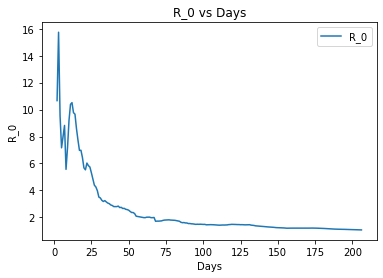

In [23]:
r_list = []

for t in range(2, 207):
    r_list.append(ro_t(t))

T = [*range(2, 207)]

plt.figure()
r0_plot = sns.lineplot(x=T, y=r_list, label='R_0')
r0_plot.set_title('R_0 vs Days')
r0_plot.set_xlabel('Days')
r0_plot.set_ylabel('R_0')

# Q1 - 10

Since $R_{0}$ is 1.067 on 15 Oct 2020. Since $R_{0}$ > 1, which implies peak is not passed till 15 Oct 2020.

In [25]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y



## **Question : 2** 


**Steepest Descent and Newton's Line Search Methods**


1. Find the minima $x^*$ for the given functions $f_1(x)$ and  $f_2(x)$ using your own implementation of Steepest Descent. Compute the step lenght by implementing the backtracking algorithm (Algorithm 3.1 Nocedal and Wright) with $\rho = 0.9$ and $c = 10^{-4}$. **[1.5 Points]**

2. Find the minima $x^*$ for the given functions $f_1(x)$ and  $f_2(x)$ using your own implementation of Newton's Method. **[1 Point]**

Notes:
1. Run both algorithms for two initial guesses. i. $x_0=(2,0)$ and ii. $x_0=(2,2)$
2. Stop iterations when $||x_{k+1} - x_{k}||_2^2 < 10^{-5}$
3. For each case report the solution and the number of iterations to converge. Also comment on the reported number of iterations.
4. Show the function contour plot and the iterates {$x_k$} including the solution.

Consider the following quadratic functions:
1. $f_1(x) = \frac{1}{2} x^T A_1 x $
  
  where 
$A_1 = 
  \begin{pmatrix}
  1 & 0 \\
  0 & 1 \\
  \end{pmatrix}$

2. $f_2(x) = \frac{1}{2} x^T A_2 x $
  
  where 
$A_2 = 
  \begin{pmatrix}
  10 & 8 \\
  8 & 10 \\
  \end{pmatrix}$



<!-- ![Derivation](jacobian.jpg) -->

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def cal_func(A,x):
    """Calculating funcion value at given input x"""
    return (0.5)*(x.T)@(A)@(x)

def der_func(A,x):
    """Calculating derivative of function given input x"""
    return A@x

In [28]:
def plot_contour(X_V, Y_V, A):
    """
    
    Coutour plotting function given values of inputs and function values
    
    """
    x1_range = np.arange(-3,3.1,0.1)
    x2_range = x1_range.reshape(-1,1)

    [X, Y] = np.meshgrid(x1_range, x2_range)

    Z = []
    for lis in range(len(X)):
        z_row = []
        for ind in range(len(X[lis])):
            z_row.append(cal_func(A,np.array([X[lis][ind],Y[lis][ind]])))
        Z.append(z_row)

    ax = plt.contour(X,Y,Z,levels = 50)
    ax = plt.plot(X_V,Y_V,'b*-',animated = True)
    plt.show()
    
    return None

In [29]:
def steepest_gradient(A, X_INIT, alpha = 0.9, rho = 0.9, c = 10**(-4)):
    """
    
    Implementation of steepest gradient descent method:
    A = Function co-efficient
    X_INIT = Initial guess
    
    """
    x_current = X_INIT
    
    iteration = 0
    print(f'Intial X_0: \n{x_current}\n A : \n{A}')
    
    # Colleting X_current X for plotting in X_V and Y_V
    X_V = []
    X_V.append(x_current[0][0])

    Y_V = []
    Y_V.append(x_current[1][0])

    while True:
        # calculating derivative at current X
        nebla_f = der_func(A, x_current)
        p_k = -nebla_f/np.linalg.norm(nebla_f)

        # alpha (step length) calculation by backtracking implementation
        while cal_func(A,x_current + alpha*p_k).squeeze() > (cal_func(A,x_current) + c*alpha*(nebla_f.T@p_k)).squeeze():
            alpha = alpha*rho
        if iteration%10 == 0:
            print(f'ITR : {iteration} and alpha (step_size) : {alpha}')

        # steepest desecent
        x_next = x_current + alpha*p_k

        #check convergence condition
        if np.square(np.linalg.norm(x_next - x_current)) < 10**(-5):
            print('Converged',end = ' ')
            x_current = x_next
            X_V.append(x_current[0][0])
            Y_V.append(x_current[1][0])
            break

        # assignong x_next 
        x_current = x_next
        X_V.append(x_current[0][0])
        Y_V.append(x_current[1][0])

        # counting iterations
        iteration += 1

    print(f'in {iteration} iterations \nSolution: \n{x_current}' )
    
    plot_contour(X_V, Y_V, A)
    
    return None

In [30]:
def newtons_method(A,x_current,alpha = 1):
    """ 
    The newton's method implementation:
    
    A = Coefficient Matrix
    x_current = Intial Guess
    alpha = step length (default = 1)
    
    """
    # Newtons Method
    iteration = 0
    print(f'Intial X_0: \n{x_current}\n A : \n{A}')

    # Colleting X_current X for plotting in X_V and Y_V
    
    X_V = []
    X_V.append(x_current[0][0])

    Y_V = []
    Y_V.append(x_current[1][0])

    while True:
        # calculating derivative at current X and p_k
        nebla_f = der_func(A, x_current)
        p_k = -np.linalg.inv(A.T)@nebla_f

        # newtons method
        x_next = x_current + alpha*p_k

        #check convergence condition
        if np.square(np.linalg.norm(x_next - x_current)) < 10**(-5):
            print('Converged',end = ' ')
            x_current = x_next
            X_V.append(x_current[0][0])
            Y_V.append(x_current[1][0])
            break

        # assignong x_next 
        x_current = x_next
        X_V.append(x_current[0][0])
        Y_V.append(x_current[1][0])

        # counting iterations
        iteration += 1

    print(f'in {iteration} iterations \nSolution: \n{x_current}' )

    plot_contour(X_V, Y_V, A)
    
    return None

In [31]:
# Coefficient matrix
A1 = np.array([[1.0,0.],[0.,1.]])
A2 = np.array([[10.,8.],[8.,10.]])

# Initial Guess
X_01 = np.array([[2.],[0.]])
X_02 = np.array([[2.],[2.]])

# Steepest Gradient Descent

Intial X_0: 
[[2.]
 [0.]]
 A : 
[[1. 0.]
 [0. 1.]]
ITR : 0 and alpha (step_size) : 0.9
ITR : 10 and alpha (step_size) : 0.16677181699666577
ITR : 20 and alpha (step_size) : 0.0225283995449392
ITR : 30 and alpha (step_size) : 0.0041745579179292966
Converged in 32 iterations 
Solution: 
[[-0.00152095]
 [ 0.        ]]


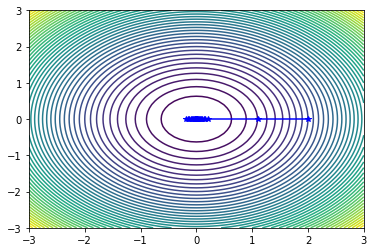

In [32]:
steepest_gradient(A1,X_01)

Intial X_0: 
[[2.]
 [0.]]
 A : 
[[10.  8.]
 [ 8. 10.]]
ITR : 0 and alpha (step_size) : 0.9
ITR : 10 and alpha (step_size) : 0.43046721000000016
ITR : 20 and alpha (step_size) : 0.0523347633027361
ITR : 30 and alpha (step_size) : 0.00636268544113595
Converged in 36 iterations 
Solution: 
[[0.00110639]
 [0.00063714]]


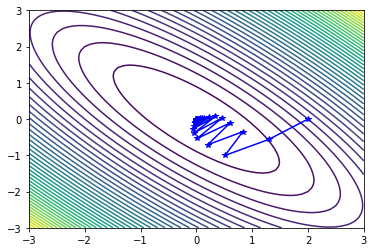

In [33]:
steepest_gradient(A2,X_01)

Intial X_0: 
[[2.]
 [2.]]
 A : 
[[1. 0.]
 [0. 1.]]
ITR : 0 and alpha (step_size) : 0.9
ITR : 10 and alpha (step_size) : 0.0984770902183612
ITR : 20 and alpha (step_size) : 0.01824800363140075
ITR : 30 and alpha (step_size) : 0.0041745579179292966
Converged in 32 iterations 
Solution: 
[[0.00107287]
 [0.00107287]]


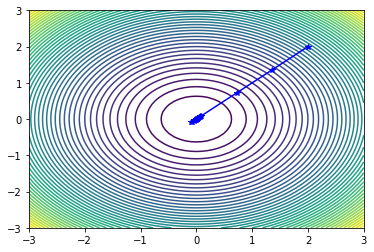

In [34]:
steepest_gradient(A1,X_02)

Intial X_0: 
[[2.]
 [2.]]
 A : 
[[10.  8.]
 [ 8. 10.]]
ITR : 0 and alpha (step_size) : 0.9
ITR : 10 and alpha (step_size) : 0.0984770902183612
ITR : 20 and alpha (step_size) : 0.01824800363140075
ITR : 30 and alpha (step_size) : 0.0041745579179292966
Converged in 32 iterations 
Solution: 
[[0.00107287]
 [0.00107287]]


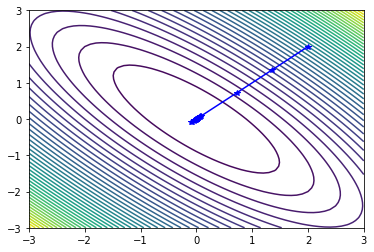

In [35]:
steepest_gradient(A2,X_02)

# Newton Method

Intial X_0: 
[[2.]
 [0.]]
 A : 
[[1. 0.]
 [0. 1.]]
Converged in 1 iterations 
Solution: 
[[0.]
 [0.]]


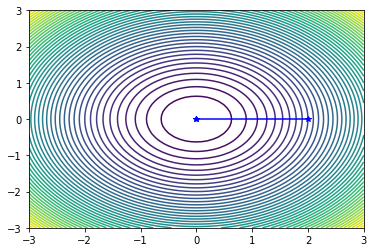

In [36]:
newtons_method(A1,X_01)

Intial X_0: 
[[2.]
 [0.]]
 A : 
[[10.  8.]
 [ 8. 10.]]
Converged in 1 iterations 
Solution: 
[[0.]
 [0.]]


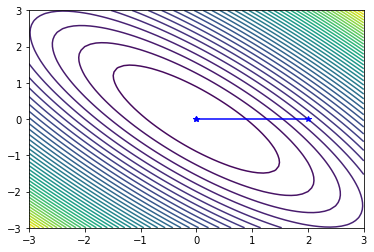

In [37]:
newtons_method(A2,X_01)

Intial X_0: 
[[2.]
 [2.]]
 A : 
[[1. 0.]
 [0. 1.]]
Converged in 1 iterations 
Solution: 
[[0.]
 [0.]]


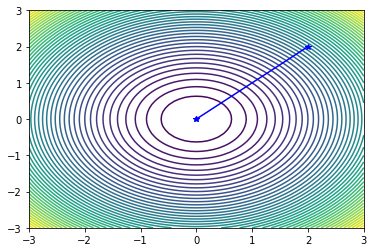

In [38]:
newtons_method(A1,X_02)

Intial X_0: 
[[2.]
 [2.]]
 A : 
[[10.  8.]
 [ 8. 10.]]
Converged in 1 iterations 
Solution: 
[[0.00000000e+00]
 [7.88860905e-31]]


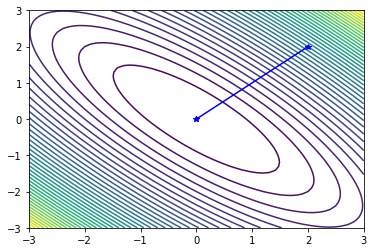

In [39]:
newtons_method(A2,X_02)

# Comment on Number of Iterations
1. Steepest Gradient is converged in 32 iteration
2. Newton Method is converged in 1 iteration due to nature 2nd order of gradient calculation at every step.

# **Question : 3**

**Rosenbrock function**

Use the steepest descent and Newtons algorithms using the backtracking line search to minimize the classic Rosenbrock function. Set the initial step length to 1. At each iteration store the step lengths used by each method and make plots. Show the step lengths taken and iterates as plots. Do these for a start point of search $x_0 = [1.2, 1.2]^T$ and then for the starting point $x_0 = [-1.2, 1]^T$ **[1 Point]**

1. Plot the convergence of the iterates and the objective function value. Evaluate the rate of convergence. **[0.5 Points]**

2. Call built-in functions for steepest descent and newton’s method, and show the results for the above. Compare and evaluate your program. Compare the run-time of your program and built-in function. Is there a difference? Why or why not? **Hint**: Jacobians! **[1 Point]**

In [40]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt


# First Initial
X_01 = np.array([[1.2],[1.2]])
X_02 = np.array([[-1.2],[1.]])

The Rosenbrock function is
$$f(x,y) = 100(y-x^{2})^{2} + (1-x)^{2}$$

Gradient
$$  grad(f) = \Bigg [\begin{matrix} 400x^{3} - 400xy + 2x -2 \\ 200(y-x^{2}) \end{matrix} \Bigg ]$$

Hessian 

$$ hess(f) = \Bigg [\begin{matrix} 1200x^{2} - 400y + 2 & -400x \\ -400x & 200) \end{matrix} \Bigg ]$$

In [41]:
def rosen(inputs):
    x, y = inputs
    return 100*(y-x**2)**2 + (1-x)**2



def rosen_der(inputs):
    x, y = inputs
    del_1 = 400*(x**3) - 400*x*y + 2*x - 2
    del_2 = 200*(y - x**2)
    
    return np.array([del_1,del_2])



def rosen_hess(inputs):
    
    x, y = inputs
    h11 = 1200*x**2 - 400*y + 2
    h12 = -400*x
    h21 = -400*x
    h22 = 200
    
    return np.array([[h11,h12],[h21,h22]],dtype = np.float32)

In [42]:
def plot_contour3(x1_list, x2_list):
    """
    Plotting contour from X's over the iterations
    
    """
    x1_range = np.arange(-5,5.1,0.1)
    x2_range = x1_range.reshape(-1,1)

    [X, Y] = np.meshgrid(x1_range, x2_range)

    Z = []
    for lis in range(len(X)):
        z_row = []
        for ind in range(len(X[lis])):
            z_row.append(rosen(np.array([X[lis][ind],Y[lis][ind]])))
        Z.append(z_row)

    ax = plt.contour(X,Y,Z,levels = 50)
    ax = plt.plot(x1_list,x2_list,'r*-',animated = True)
    plt.show()
    
    return None

In [43]:
def steepest_algo(X_INIT, alpha = 1, rho = 0.9, c = 10**(-4),plot = True, verbose = True):
    
    """
    Steepest Gradient Descent Implementation for Rosenrock function
    
    """
    
    iteration = 0
    x_current = X_INIT
    if verbose:
        print(f'Intial X_0: \n{x_current}\n')

    # for plotting of coutour 
    x1_collector = []
    x1_collector.append(x_current[0][0])

    x2_collector = []
    x2_collector.append(x_current[1][0])

    while True:
        # calculating derivative at current X
        
        nebla_f = rosen_der(x_current)
        p_k = -nebla_f/np.linalg.norm(nebla_f)

        # alpha (step length) calculation by backtracking implementation
        while rosen(x_current + alpha*p_k).squeeze() > (rosen(x_current) + c*alpha*(nebla_f.T@p_k)).squeeze():
            alpha = alpha*rho
        if iteration % 1000 == 0 and verbose:
            print(f'ITR : {iteration} and alpha (step_size) : {alpha}')

        # steepest desecent
        x_next = x_current + alpha*p_k

        #check convergence condition
        if np.square(np.linalg.norm(x_next - x_current)) < 10**(-8):
            if verbose:
                print('Converged',end = ' ')
            x_current = x_next
            x1_collector.append(x_current[0][0])
            x2_collector.append(x_current[1][0])
            break

        # assignong x_next 
        x_current = x_next
        x1_collector.append(x_current[0][0])
        x2_collector.append(x_current[1][0])

        # counting iterations
        iteration += 1

    if verbose:
        print(f'in {iteration} iterations\n \nSolution: \n{x_current}' )
    if plot:
        plot_contour3(x1_collector,x2_collector)
    
    return [x1_collector, x2_collector]

In [44]:
def newton_algo(X_INIT, alpha = 1, plot = True, verbose = True):
    
    """
    Newtons Methods Implementation for Rosenrock function
    
    """
    
    
    iteration = 0
    x_current = X_INIT    

    x1_collector = []
    x1_collector.append(x_current[0][0])

    x2_collector = []
    x2_collector.append(x_current[1][0])
    
    if verbose:
        print(f'Intial X_0: \n{x_current}\n')
    
    while True:
    
        # calculating derivative at current X and p_k
        nebla_f = rosen_der(x_current)
        p_k = -np.linalg.inv(rosen_hess(x_current))@nebla_f

        # newtons method
        x_next = x_current + alpha*p_k

        #check convergence condition
        if np.square(np.linalg.norm(x_next - x_current)) < 10**(-5):
            if verbose:
                print('Converged',end = ' ')
            x_current = x_next
            x1_collector.append(x_current[0][0])
            x2_collector.append(x_current[1][0])
            break

        # assignong x_next 
        x_current = x_next
        x1_collector.append(x_current[0][0])
        x2_collector.append(x_current[1][0])
        
        # counting iterations
        iteration += 1
        
    if verbose:
        print(f'in {iteration} iterations\n \nSolution: \n{x_current}')

    if plot:
        plot_contour3(x1_collector,x2_collector)
    
    return [x1_collector, x2_collector]

In [45]:
def converge_plots(x1,x2):
    import seaborn as sns
    X = np.array([x1,x2])
    function_values = rosen(X)
    print('Function values vs Iteration')
    fig = sns.lineplot(x = np.arange(1,len(function_values)+1,1), y = function_values)
    plt.xlabel("Iteration")
    plt.ylabel("Function Value")
    plt.show(fig)
    
    plt.figure()
    
    print('X values during optimization Plot')
    sns.lineplot(x = x1, y = x2)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title('[X] = [x1,x2]')
    plt.show(fig)
    
    return None

In [46]:
def calculate_rate_convergence(x1,x2,x_star,q):
    X = np.array([x1,x2])
    X = X.T
    k = len(X)-2
    print(f'Rate of convergence is {np.linalg.norm(X[k+1] - x_star)/(np.linalg.norm(X[k] - x_star)**q)}')

Intial X_0: 
[[1.2]
 [1.2]]

ITR : 0 and alpha (step_size) : 0.1853020188851842
ITR : 1000 and alpha (step_size) : 0.0022185312344622636
ITR : 2000 and alpha (step_size) : 0.0014555783429306911
ITR : 3000 and alpha (step_size) : 0.0006265787482177979
ITR : 4000 and alpha (step_size) : 0.0006265787482177979
ITR : 5000 and alpha (step_size) : 0.00011610630703530947
ITR : 6000 and alpha (step_size) : 0.00011610630703530947
Converged in 6099 iterations
 
Solution: 
[[1.00110787]
 [1.00213583]]


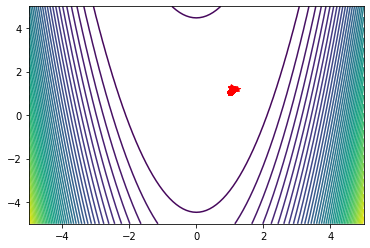

Function values vs Iteration


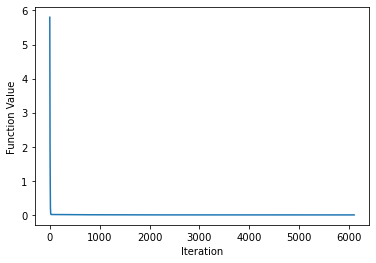

X values during optimization Plot


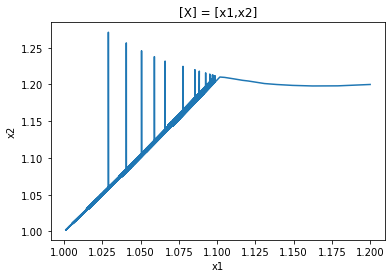

Rate of convergence is 0.9992224775883028


In [47]:
x1,x2 = steepest_algo(X_01)
converge_plots(x1,x2)
calculate_rate_convergence(x1,x2,x_star = [1,1],q=1)

Intial X_0: 
[[-1.2]
 [ 1. ]]

ITR : 0 and alpha (step_size) : 0.38742048900000015
ITR : 1000 and alpha (step_size) : 0.00515377520732012
ITR : 2000 and alpha (step_size) : 0.0022185312344622636
ITR : 3000 and alpha (step_size) : 0.0014555783429306911
ITR : 4000 and alpha (step_size) : 0.0006265787482177979
ITR : 5000 and alpha (step_size) : 0.00017696434542799794
ITR : 6000 and alpha (step_size) : 0.00017696434542799794
Converged in 6639 iterations
 
Solution: 
[[0.99902239]
 [0.99795674]]


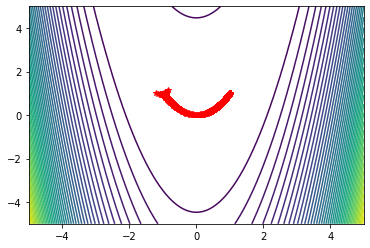

Function values vs Iteration


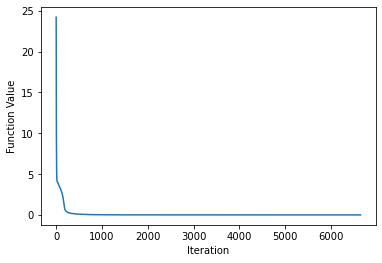

X values during optimization Plot


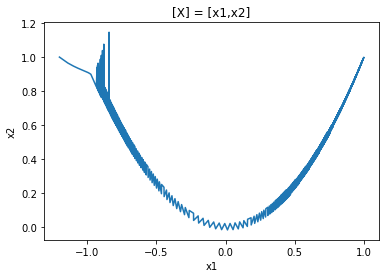

Rate of convergence is 0.9992116136940586


In [48]:
x1,x2 = steepest_algo(X_02)

converge_plots(x1,x2)

calculate_rate_convergence(x1,x2,x_star = [1,1],q=1)

Intial X_0: 
[[1.2]
 [1.2]]

Converged in 3 iterations
 
Solution: 
[[0.99999999]
 [0.99999964]]


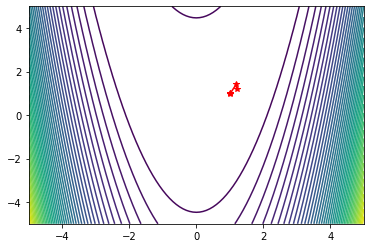

Function values vs Iteration


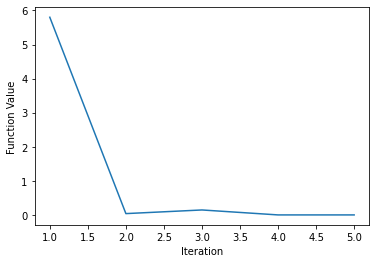

X values during optimization Plot


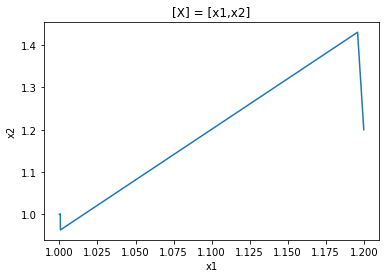

Rate of convergence is 0.21041305325348


In [49]:
x1,x2 = newton_algo(X_01)

converge_plots(x1, x2)

calculate_rate_convergence(x1,x2,x_star = [1,1], q=2)

Intial X_0: 
[[-1.2]
 [ 1. ]]

Converged in 5 iterations
 
Solution: 
[[1.]
 [1.]]


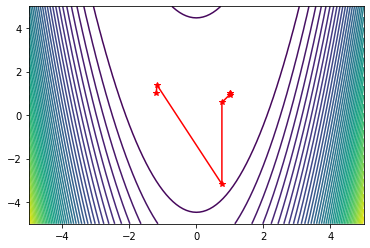

Function values vs Iteration


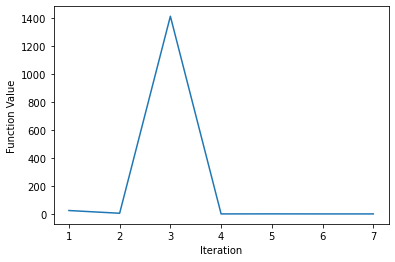

X values during optimization Plot


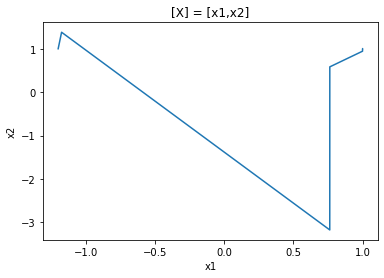

Rate of convergence is 0.19774244731711163


In [50]:
x1,x2 = newton_algo(X_02)

converge_plots(x1, x2)

calculate_rate_convergence(x1, x2, x_star = [1,1], q = 2)

# In-Built Functions

In [51]:
from scipy.optimize import root, newton
from scipy.optimize import rosen as rosen_inbuilt
from scipy.optimize import line_search

In [52]:
# Newton inbuilt implementation 
results = newton(rosen_inbuilt, X_01.squeeze())
print(results)

results = newton(rosen_inbuilt, X_02.squeeze(), maxiter=50000)
print(results)

[1.00000002 1.00000002]
[-0.52384781  0.38531619]


In [53]:
def line_search_inbulit(X0,verbose = True):
    X01 = X0
    iteration = 0
    while True:

        iteration += 1

        alpha, fc, gc, new_ev, old_ev, slope = line_search(rosen, rosen_der, xk=X01, pk= -rosen_der(X01)/np.linalg.norm(rosen_der(X01)), maxiter=10000)

        if alpha:
            X02 = X01 + alpha*(-rosen_der(X01)/np.linalg.norm(rosen_der(X01)))

            if np.linalg.norm(X02 - X01)**2 < 10**(-8):
                if verbose:
                    print(f'Solution is {X02}')
                    print(f'Number of iteration {iteration}')
                break
        else:
            break

        X01 = X02

In [54]:

line_search_inbulit(X_01.squeeze())

print('----------------------------------')

line_search_inbulit(X_02.squeeze())


Solution is [1.03075984 1.06249925]
Number of iteration 7
----------------------------------
Solution is [0.96332146 0.92776262]
Number of iteration 1131


# Time Comparision - Steepest Descent

In [55]:
import time

t1_start = time.perf_counter_ns()

line_search_inbulit(X_01.squeeze(),verbose = False)

t1_stop = time.perf_counter_ns()

print(f'In-Built Line Search took {(t1_stop - t1_start):.19f} nano-seconds')



t2_start = time.perf_counter_ns()

x1,x2 = steepest_algo(X_01, plot = False, verbose = False)

t2_stop = time.perf_counter_ns()

print(f'Steepest gradient took {(t2_stop - t2_start):.19f} nano-seconds')

In-Built Line Search took 3677700.0000000000000000000 nano-seconds
Steepest gradient took 248207400.0000000000000000000 nano-seconds


**In-built Steepest Descent Method consist of elegent use of vectorize implementation and my own implementation consist of loops, Hence own implementation is slow as compare to inbuilt. Further more, the jacobian used is explicity written function for both implementation.**

# Time Comparison - Newton Method

In [56]:
t1_start = time.perf_counter_ns()

results = newton(rosen_inbuilt, X_01.squeeze())

t1_stop = time.perf_counter_ns()

print(f'In-Built Newton took {(t1_stop - t1_start):.19f} nano-seconds')



t2_start = time.perf_counter_ns()

x1,x2 = newton_algo(X_01, plot = False, verbose = False)

t2_stop = time.perf_counter_ns()

print(f'Own Newton implementation took {(t2_stop - t2_start):.19f} nano-seconds')

In-Built Newton took 2422900.0000000000000000000 nano-seconds
Own Newton implementation took 475200.0000000000000000000 nano-seconds


**Inbuilt Newton Method calculating Hessain by numerial approximation (Finite Difference Method) and my own implementation calculating Hessian by explicit calculations, Hence own implementation is fast as compare to inbuilt**